##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Parametrized Quantum Circuits for Reinforcement Learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/quantum_reinforcement_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/quantum_reinforcement_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/quantum_reinforcement_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/quantum_reinforcement_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Quantum computers have been shown to provide computational advantages in certain problem areas. The field of quantum reinforcement learning (QRL) aims to harness this boost by designing RL agents that rely on quantum models of computation.

In this tutorial, you will implement two reinforcement learning algorithms based on parametrized/variational quantum circuits (PQCs or VQCs), namely a policy-gradient and a deep Q-learning implementation. These algorithms were introduced by [[1] Jerbi et al.](https://arxiv.org/abs/2103.05577) and [[2] Skolik et al.](https://arxiv.org/abs/2103.15084), respectively.

You will implement a PQC with data re-uploading in TFQ, and use it as:
1. an RL policy trained with a policy-gradient method,
2. a Q-function approximator trained with deep Q-learning,

each solving [CartPole-v1](https://gymnasium.farama.org/environments/classic_control/cart_pole/), a benchmarking task from Gymnasium. Note that, as showcased in [[1]](https://arxiv.org/abs/2103.05577) and [[2]](https://arxiv.org/abs/2103.15084), these agents can also be used to solve other task-environment from Gymnasium, such as [FrozenLake-v1](https://gymnasium.farama.org/environments/toy_text/frozen_lake/), [MountainCar-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car/) or [Acrobot-v1](https://gymnasium.farama.org/environments/classic_control/acrobot/).

Features of this implementation:
- you will learn how to use a `tfq.layers.ControlledPQC` to implement a PQC with data re-uploading, appearing in many applications of QML. This implementation also naturally allows using trainable scaling parameters at the input of the PQC, to increase its expressivity,
- you will learn how to implement observables with trainable weights at the output of a PQC, to allow a flexible range of output values,
- you will learn how a `tf.keras.Model` can be trained with non-trivial ML loss functions, i.e., that are not compatible with `model.compile` and `model.fit`, using a `tf.GradientTape`.

## Setup

Install TensorFlow and TensorFlow Quantum:

In [ ]:
# In Colab, you will be asked to restart the session after this finishes.
!pip install tensorflow==2.16.2 tensorflow-quantum==0.7.5

Configure the use of Keras 2:

In [1]:
# Keras 2 must be selected before importing TensorFlow or TensorFlow Quantum:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

Install Gymnasium:

In [ ]:
!pip install gymnasium[classic-control]==1.2.3

Now import TensorFlow, TensorFlow Quantum, and other modules needed:

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import gymnasium as gym
import cirq
import sympy
import numpy as np
from functools import reduce
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

tf.get_logger().setLevel('ERROR')

## 1. Build a PQC with data re-uploading

At the core of both RL algorithms you are implementing is a PQC that takes as input the agent's state $s$ in the environment (i.e., a numpy array) and outputs a vector of expectation values. These expectation values are then post-processed, either to produce an agent's policy $\pi(a|s)$ or approximate Q-values $Q(s,a)$. In this way, the PQCs are playing an analog role to that of deep neural networks in modern deep RL algorithms.

A popular way to encode an input vector in a PQC is through the use of single-qubit rotations, where rotation angles are controlled by the components of this input vector. In order to get a [highly-expressive model](https://arxiv.org/abs/2008.08605), these single-qubit encodings are not performed only once in the PQC, but in several "[re-uploadings](https://quantum-journal.org/papers/q-2020-02-06-226/)", interlayed with variational gates. The layout of such a PQC is depicted below:

<img src="./images/pqc_re-uploading.png" width="700">

As discussed in [[1]](https://arxiv.org/abs/2103.05577) and [[2]](https://arxiv.org/abs/2103.15084), a way to further enhance the expressivity and trainability of data re-uploading PQCs is to use trainable input-scaling parameters $\boldsymbol{\lambda}$ for each encoding gate of the PQC, and trainable observable weights $\boldsymbol{w}$ at its output.

### 1.1 Cirq circuit for ControlledPQC

The first step is to implement in Cirq the quantum circuit to be used as the PQC. For this, start by defining basic unitaries to be applied in the circuits, namely an arbitrary single-qubit rotation and an entangling layer of CZ gates:

In [3]:
def one_qubit_rotation(qubit, symbols):
    """
    Returns Cirq gates that apply a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    """
    return [
        cirq.rx(symbols[0])(qubit),
        cirq.ry(symbols[1])(qubit),
        cirq.rz(symbols[2])(qubit)
    ]


def entangling_layer(qubits):
    """
    Returns a layer of CZ entangling gates on `qubits` (arranged in a circular topology).
    """
    cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    cz_ops += ([cirq.CZ(qubits[0], qubits[-1])] if len(qubits) != 2 else [])
    return cz_ops

Now, use these functions to generate the Cirq circuit:

In [4]:
def generate_circuit(qubits, n_layers):
    """Prepares a data re-uploading circuit on `qubits` with `n_layers` layers."""
    # Number of qubits
    n_qubits = len(qubits)

    # Sympy symbols for variational angles
    params = sympy.symbols(f'theta(0:{3*(n_layers+1)*n_qubits})')
    params = np.asarray(params).reshape((n_layers + 1, n_qubits, 3))

    # Sympy symbols for encoding angles
    inputs = sympy.symbols(f'x(0:{n_layers})' + f'_(0:{n_qubits})')
    inputs = np.asarray(inputs).reshape((n_layers, n_qubits))

    # Define circuit
    circuit = cirq.Circuit()
    for l in range(n_layers):
        # Variational layer
        circuit += cirq.Circuit(
            one_qubit_rotation(q, params[l, i]) for i, q in enumerate(qubits))
        circuit += entangling_layer(qubits)
        # Encoding layer
        circuit += cirq.Circuit(
            cirq.rx(inputs[l, i])(q) for i, q in enumerate(qubits))

    # Last varitional layer
    circuit += cirq.Circuit(
        one_qubit_rotation(q, params[n_layers, i])
        for i, q in enumerate(qubits))

    return circuit, list(params.flat), list(inputs.flat)

Check that this produces a circuit that is alternating between variational and encoding layers.

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

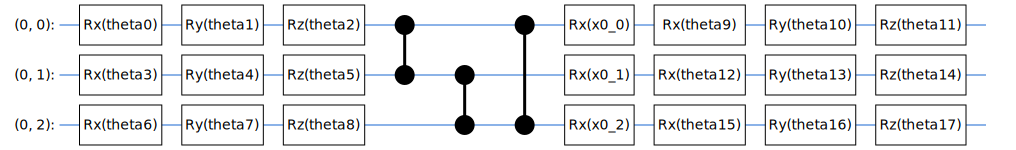

In [32]:
n_qubits, n_layers = 3, 1
qubits = cirq.GridQubit.rect(1, n_qubits)
circuit, _, _ = generate_circuit(qubits, n_layers)
SVGCircuit(circuit)

### 1.2 ReUploadingPQC layer using ControlledPQC

To construct the re-uploading PQC from the figure above, you can create a custom Keras layer. This layer will manage the trainable parameters (variational angles $\boldsymbol{\theta}$ and input-scaling parameters $\boldsymbol{\lambda}$) and resolve the input values (input state $s$) into the appropriate symbols in the circuit.

In [6]:
class ReUploadingPQC(tf.keras.layers.Layer):
    """
    Performs the transformation (s_1, ..., s_d) -> (theta_1, ..., theta_N, lmbd[1][1]s_1, ..., lmbd[1][M]s_1,
        ......., lmbd[d][1]s_d, ..., lmbd[d][M]s_d) for d=input_dim, N=theta_dim and M=n_layers.
    An activation function from tf.keras.activations, specified by `activation` ('linear' by default) is
        then applied to all lmbd[i][j]s_i.
    All angles are finally permuted to follow the alphabetical order of their symbol names, as processed
        by the ControlledPQC.
    """

    def __init__(self,
                 qubits,
                 n_layers,
                 observables,
                 activation="linear",
                 name="re-uploading_PQC"):
        super(ReUploadingPQC, self).__init__(name=name)
        self.n_layers = n_layers
        self.n_qubits = len(qubits)

        circuit, theta_symbols, input_symbols = generate_circuit(
            qubits, n_layers)

        theta_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
        self.theta = tf.Variable(initial_value=theta_init(
            shape=(1, len(theta_symbols)), dtype="float32"),
                                 trainable=True,
                                 name="thetas")

        lmbd_init = tf.ones(shape=(self.n_qubits * self.n_layers,))
        self.lmbd = tf.Variable(initial_value=lmbd_init,
                                dtype="float32",
                                trainable=True,
                                name="lambdas")

        # Define explicit symbol order.
        symbols = [str(symb) for symb in theta_symbols + input_symbols]
        self.indices = tf.constant([symbols.index(a) for a in sorted(symbols)])

        self.activation = activation
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
        self.computation_layer = tfq.layers.ControlledPQC(circuit, observables)

    def call(self, inputs):
        # inputs[0] = encoding data for the state.
        batch_dim = tf.gather(tf.shape(inputs[0]), 0)
        tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
        tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim, 1])
        tiled_up_inputs = tf.tile(inputs[0], multiples=[1, self.n_layers])
        scaled_inputs = tf.einsum("i,ji->ji", self.lmbd, tiled_up_inputs)
        squashed_inputs = tf.keras.layers.Activation(
            self.activation)(scaled_inputs)

        joined_vars = tf.concat([tiled_up_thetas, squashed_inputs], axis=1)
        joined_vars = tf.gather(joined_vars, self.indices, axis=1)

        return self.computation_layer([tiled_up_circuits, joined_vars])

## 2. Policy-gradient RL with PQC policies

In this section, you will implement the policy-gradient algorithm presented in <a href="https://arxiv.org/abs/2103.05577" class="external">[1]</a>. For this, you will start by constructing, out of the PQC that was just defined, the `softmax-VQC` policy (where VQC stands for variational quantum circuit):
$$ \pi_\theta(a|s) = \frac{e^{\beta \langle O_a \rangle_{s,\theta}}}{\sum_{a'} e^{\beta \langle O_{a'} \rangle_{s,\theta}}} $$
where $\langle O_a \rangle_{s,\theta}$ are expectation values of observables $O_a$ (one per action) measured at the output of the PQC, and $\beta$ is a tunable inverse-temperature parameter. 

You can adopt the same observables used in <a href="https://arxiv.org/abs/2103.05577" class="external">[1]</a> for CartPole, namely a global $Z_0Z_1Z_2Z_3$ Pauli product acting on all qubits, weighted by an action-specific weight for each action. To implement the weighting of the Pauli product, you can use an extra `tf.keras.layers.Layer` that stores the action-specific weights and applies them multiplicatively on the expectation value $\langle Z_0Z_1Z_2Z_3 \rangle_{s,\theta}$.

In [7]:
class Alternating(tf.keras.layers.Layer):

    def __init__(self, output_dim):
        super(Alternating, self).__init__()
        self.w = tf.Variable(initial_value=tf.constant([[
            (-1.)**i for i in range(output_dim)
        ]]),
                             dtype="float32",
                             trainable=True,
                             name="obs-weights")

    def call(self, inputs):
        return tf.matmul(inputs, self.w)

Prepare the definition of your PQC:

In [8]:
n_qubits = 4  # Dimension of the state vectors in CartPole
n_layers = 5  # Number of layers in the PQC
n_actions = 2  # Number of actions in CartPole

qubits = cirq.GridQubit.rect(1, n_qubits)

and its observables:

In [9]:
ops = [cirq.Z(q) for q in qubits]
observables = [reduce((lambda x, y: x * y), ops)]  # Z_0*Z_1*Z_2*Z_3

With this, define a `tf.keras.Model` that applies, sequentially, the `ReUploadingPQC` layer previously defined, followed by a post-processing layer that computes the weighted observables using `Alternating`, which are then fed into a `tf.keras.layers.Softmax` layer that outputs the `softmax-VQC` policy of the agent.

In [10]:
def generate_model_policy(qubits, n_layers, n_actions, beta, observables):
    """Generates a Keras model for a data re-uploading PQC policy."""

    input_tensor = tf.keras.Input(shape=(len(qubits),),
                                  dtype=tf.dtypes.float32,
                                  name='input')
    re_uploading_pqc = ReUploadingPQC(qubits, n_layers,
                                      observables)([input_tensor])
    process = tf.keras.Sequential([
        Alternating(n_actions),
        tf.keras.layers.Lambda(lambda x: x * beta),
        tf.keras.layers.Softmax()
    ],
                                  name="observables-policy")
    policy = process(re_uploading_pqc)
    model = tf.keras.Model(inputs=[input_tensor], outputs=policy)

    return model


model = generate_model_policy(qubits, n_layers, n_actions, 1.0, observables)

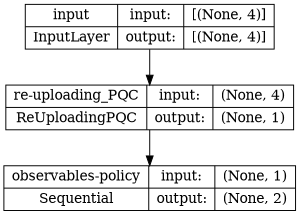

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

You can now train the PQC policy on CartPole-v1, using, e.g., the basic `REINFORCE` algorithm (see Alg. 1 in <a href="https://arxiv.org/abs/2103.05577" class="external">[1]</a>). Pay attention to the following points:
1. Because scaling parameters, variational angles and observables weights are trained with different learning rates, it is convenient to define 3 separate optimizers with their own learning rates, each updating one of these groups of parameters.
2. The loss function in policy-gradient RL is
    $$ \mathcal{L}(\theta) = -\frac{1}{|\mathcal{B}|}\sum_{s_0,a_0,r_1,s_1,a_1, \ldots \in \mathcal{B}} \left(\sum_{t=0}^{H-1} \log(\pi_\theta(a_t|s_t)) \sum_{t'=1}^{H-t} \gamma^{t'} r_{t+t'} \right)$$
for a batch $\mathcal{B}$ of episodes $(s_0,a_0,r_1,s_1,a_1, \ldots)$ of interactions in the environment following the policy $\pi_\theta$. This is different from a supervised learning loss with fixed target values that the model should fit, which make it impossible to use a simple function call like `model.fit` to train the policy. Instead, using a `tf.GradientTape` allows to keep track of the computations involving the PQC (i.e., policy sampling) and store their contributions to the loss during the interaction. After running a batch of episodes, you can then apply backpropagation on these computations to get the gradients of the loss with respect to the PQC parameters and use the optimizers to update the policy-model.

Start by defining a function that gathers episodes of interaction with the environment:

In [12]:
def gather_episodes(state_bounds, n_actions, model, n_episodes, env_name):
    """Interact with environment in batched fashion."""

    trajectories = [defaultdict(list) for _ in range(n_episodes)]
    envs = [gym.make(env_name) for _ in range(n_episodes)]

    done = [False for _ in range(n_episodes)]
    states = []
    for i, env in enumerate(envs):
        state, _ = env.reset()
        states.append(state)

    while not all(done):
        unfinished_ids = [i for i in range(n_episodes) if not done[i]]
        normalized_states = [
            s / state_bounds for i, s in enumerate(states) if not done[i]
        ]

        for i, state in zip(unfinished_ids, normalized_states):
            trajectories[i]['states'].append(state)

        # Compute policy for all unfinished envs in parallel
        states = tf.convert_to_tensor(normalized_states)
        action_probs = model([states])

        # Store action and transition all environments to the next state
        states = [None for i in range(n_episodes)]
        for i, policy in zip(unfinished_ids, action_probs.numpy()):
            action = np.random.choice(n_actions, p=policy)
            states[i], reward, terminated, truncated, _ = envs[i].step(action)
            done[i] = terminated or truncated
            trajectories[i]['actions'].append(action)
            trajectories[i]['rewards'].append(reward)

    return trajectories

and a function that computes discounted returns $\sum_{t'=1}^{H-t} \gamma^{t'} r_{t+t'}$ out of the rewards $r_t$ collected in an episode:

In [13]:
def compute_returns(rewards_history, gamma):
    """Compute discounted returns with discount factor `gamma`."""
    returns = []
    discounted_sum = 0
    for r in rewards_history[::-1]:
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    # Normalize them for faster and more stable learning
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = returns.tolist()

    return returns

Define the hyperparameters:

In [14]:
state_bounds = np.array([2.4, 2.5, 0.21, 2.5])
gamma = 1
batch_size = 10
n_episodes = 1000

Prepare the optimizers:

In [15]:
optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.01, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2

Implement a function that updates the policy using states, actions and returns:

In [16]:
@tf.function
def reinforce_update(states, actions, returns, model):
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    returns = tf.convert_to_tensor(returns)

    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        logits = model(states)
        p_actions = tf.gather_nd(logits, actions)
        log_probs = tf.math.log(p_actions)
        loss = tf.math.reduce_sum(-log_probs * returns) / batch_size
    grads = tape.gradient(loss, model.trainable_variables)
    for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out],
                            [w_in, w_var, w_out]):
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])

Now implement the main training loop of the agent.

Note: This agent may need to simulate several million quantum circuits and can take as much as ~20 minutes to finish training.

In [17]:
env_name = "CartPole-v1"

# Start training the agent
episode_reward_history = []
for batch in range(n_episodes // batch_size):
    # Gather episodes
    episodes = gather_episodes(state_bounds, n_actions, model, batch_size,
                               env_name)

    # Group states, actions and returns in numpy arrays
    states = np.concatenate([ep['states'] for ep in episodes])
    actions = np.concatenate([ep['actions'] for ep in episodes])
    rewards = [ep['rewards'] for ep in episodes]
    returns = np.concatenate(
        [compute_returns(ep_rwds, gamma) for ep_rwds in rewards])
    returns = np.array(returns, dtype=np.float32)

    id_action_pairs = np.array([[i, a] for i, a in enumerate(actions)])

    # Update model parameters.
    reinforce_update(states, id_action_pairs, returns, model)

    # Store collected rewards
    for ep_rwds in rewards:
        episode_reward_history.append(np.sum(ep_rwds))

    avg_rewards = np.mean(episode_reward_history[-10:])

    print('Finished episode', (batch + 1) * batch_size, 'Average rewards: ',
          avg_rewards)

    if avg_rewards >= 500.0:
        break

Finished episode 10 Average rewards:  16.3
Finished episode 20 Average rewards:  18.2
Finished episode 30 Average rewards:  14.8
Finished episode 40 Average rewards:  30.1
Finished episode 50 Average rewards:  21.0
Finished episode 60 Average rewards:  19.8
Finished episode 70 Average rewards:  22.8
Finished episode 80 Average rewards:  21.5
Finished episode 90 Average rewards:  26.7
Finished episode 100 Average rewards:  34.9
Finished episode 110 Average rewards:  28.5
Finished episode 120 Average rewards:  30.4
Finished episode 130 Average rewards:  49.2
Finished episode 140 Average rewards:  49.4
Finished episode 150 Average rewards:  54.9
Finished episode 160 Average rewards:  42.6
Finished episode 170 Average rewards:  100.8
Finished episode 180 Average rewards:  82.2
Finished episode 190 Average rewards:  95.5
Finished episode 200 Average rewards:  135.2
Finished episode 210 Average rewards:  141.5
Finished episode 220 Average rewards:  170.6
Finished episode 230 Average rewards:

Plot the learning history of the agent:

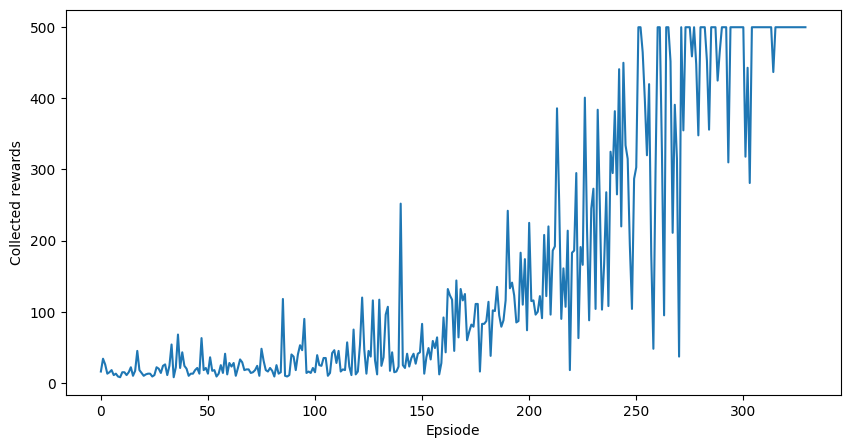

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(episode_reward_history)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()

Congratulations, you have trained a quantum policy gradient model on Cartpole! The plot above shows the rewards collected by the agent per episode throughout its interaction with the environment. You should see that after a few hundred episodes, the performance of the agent gets close to optimal, i.e., 500 rewards per episode. 

You can now visualize the performance of your agent using `env.render()` in a sample episode (uncomment/run the following cell only if your notebook has access to a display):

In [ ]:
# from PIL import Image

# env = gym.make('CartPole-v1', render_mode="rgb_array")
# state, _ = env.reset()
# frames = []
# for t in range(500):
#     im = Image.fromarray(env.render())
#     frames.append(im)
#     policy = model([tf.convert_to_tensor([state/state_bounds])])
#     action = np.random.choice(n_actions, p=policy.numpy()[0])
#     state, _, terminated, truncated, _ = env.step(action)
#     done = terminated or truncated
#     if done:
#         break
# env.close()
# frames[1].save('./images/gym_CartPole.gif',
#                save_all=True, append_images=frames[2:], optimize=False, duration=40, loop=0)

<img src="./images/gym_CartPole.gif" width="700">

## 3. Deep Q-learning with PQC Q-function approximators

In this section, you will move to the implementation of the deep Q-learning algorithm presented in <a href="https://arxiv.org/abs/2103.15084" class="external">[2]</a>. As opposed to a policy-gradient approach, the deep Q-learning method uses a PQC to approximate the Q-function of the agent. That is, the PQC defines a function approximator:
$$ Q_\theta(s,a) = \langle O_a \rangle_{s,\theta} $$
where $\langle O_a \rangle_{s,\theta}$ are expectation values of observables $O_a$ (one per action) measured at the ouput of the PQC.

These Q-values are updated using a loss function derived from Q-learning:
$$ \mathcal{L}(\theta) = \frac{1}{|\mathcal{B}|}\sum_{s,a,r,s' \in \mathcal{B}} \left(Q_\theta(s,a) - [r +\max_{a'} Q_{\theta'}(s',a')]\right)^2$$
for a batch $\mathcal{B}$ of $1$-step interactions $(s,a,r,s')$ with the environment, sampled from the replay memory, and parameters $\theta'$ specifying the target PQC (i.e., a copy of the main PQC, whose parameters are sporadically copied from the main PQC throughout learning).

You can adopt the same observables used in <a href="https://arxiv.org/abs/2103.15084" class="external">[2]</a> for CartPole, namely a $Z_0Z_1$ Pauli product for action $0$ and a $Z_2Z_3$ Pauli product for action $1$. Both observables are re-scaled so their expectation values are in $[0,1]$ and weighted by an action-specific weight. To implement the re-scaling and weighting of the Pauli products, you can define again an extra `tf.keras.layers.Layer` that stores the action-specific weights and applies them multiplicatively on the expectation values $\left(1+\langle Z_0Z_1 \rangle_{s,\theta}\right)/2$ and $\left(1+\langle Z_2Z_3 \rangle_{s,\theta}\right)/2$.

In [20]:
class Rescaling(tf.keras.layers.Layer):

    def __init__(self, input_dim):
        super(Rescaling, self).__init__()
        self.input_dim = input_dim
        self.w = tf.Variable(initial_value=tf.ones(shape=(1, input_dim)),
                             dtype="float32",
                             trainable=True,
                             name="obs-weights")

    def call(self, inputs):
        return tf.math.multiply((inputs + 1) / 2,
                                tf.repeat(self.w,
                                          repeats=tf.shape(inputs)[0],
                                          axis=0))

Prepare the definition of your PQC and its observables:

In [21]:
n_qubits = 4  # Dimension of the state vectors in CartPole
n_layers = 5  # Number of layers in the PQC
n_actions = 2  # Number of actions in CartPole

qubits = cirq.GridQubit.rect(1, n_qubits)
ops = [cirq.Z(q) for q in qubits]
observables = [ops[0] * ops[1],
               ops[2] * ops[3]]  # Z_0*Z_1 for action 0 and Z_2*Z_3 for action 1

Define a `tf.keras.Model` that, similarly to the PQC-policy model, constructs a Q-function approximator that is used to generate the main and target models of our Q-learning agent.

In [22]:
def generate_model_Qlearning(qubits, n_layers, n_actions, observables, target):
    """Generates a Keras model for a data re-uploading PQC Q-function approximator."""

    input_tensor = tf.keras.Input(shape=(len(qubits),),
                                  dtype=tf.dtypes.float32,
                                  name='input')
    re_uploading_pqc = ReUploadingPQC(qubits,
                                      n_layers,
                                      observables,
                                      activation='tanh')([input_tensor])
    process = tf.keras.Sequential([Rescaling(len(observables))],
                                  name=target * "Target" + "Q-values")
    Q_values = process(re_uploading_pqc)
    model = tf.keras.Model(inputs=[input_tensor], outputs=Q_values)

    return model


model = generate_model_Qlearning(qubits, n_layers, n_actions, observables,
                                 False)
model_target = generate_model_Qlearning(qubits, n_layers, n_actions,
                                        observables, True)

model_target.set_weights(model.get_weights())

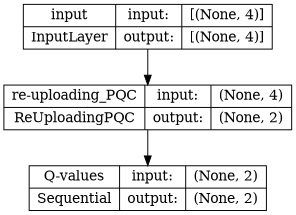

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

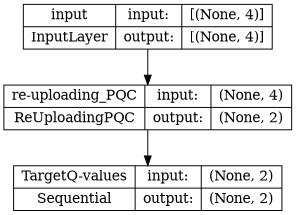

In [24]:
tf.keras.utils.plot_model(model_target, show_shapes=True, dpi=70)

You can now implement the deep Q-learning algorithm and test it on the CartPole-v1 environment. For the policy of the agent, you can use an $\varepsilon$-greedy policy:
$$ \pi(a|s) =
\begin{cases}
\delta_{a,\text{argmax}_{a'} Q_\theta(s,a')}\quad \text{w.p.}\quad 1 - \varepsilon\\
\frac{1}{\text{num\_actions}}\quad \quad \quad \quad \text{w.p.}\quad \varepsilon
\end{cases} $$
where $\varepsilon$ is multiplicatively decayed at each episode of interaction.

Start by defining a function that performs an interaction step in the environment:

In [25]:
def interact_env(state, model, epsilon, n_actions, env):
    # Preprocess state
    state_array = np.array(state)
    state = tf.convert_to_tensor([state_array])

    # Sample action
    coin = np.random.random()
    if coin > epsilon:
        q_vals = model([state])
        action = int(tf.argmax(q_vals[0]).numpy())
    else:
        action = np.random.choice(n_actions)

    # Apply sampled action in the environment, receive reward and next state
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    interaction = {
        'state': state_array,
        'action': action,
        'next_state': next_state.copy(),
        'reward': reward,
        'done': np.float32(done)
    }

    return interaction

and a function that updates the Q-function using a batch of interactions:

In [26]:
@tf.function
def Q_learning_update(states, actions, rewards, next_states, done, model, gamma,
                      n_actions):
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    rewards = tf.convert_to_tensor(rewards)
    next_states = tf.convert_to_tensor(next_states)
    done = tf.convert_to_tensor(done)

    # Compute their target q_values and the masks on sampled actions
    future_rewards = model_target([next_states])
    target_q_values = rewards + (gamma * tf.reduce_max(future_rewards, axis=1) *
                                 (1.0 - done))
    masks = tf.one_hot(actions, n_actions)

    # Train the model on the states and target Q-values
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        q_values = model([states])
        q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        loss = tf.keras.losses.Huber()(target_q_values, q_values_masked)

    # Backpropagation
    grads = tape.gradient(loss, model.trainable_variables)
    for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out],
                            [w_in, w_var, w_out]):
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])

Define the hyperparameters:

In [27]:
gamma = 0.99
n_episodes = 2000

# Define replay memory
max_memory_length = 10000  # Maximum replay length
replay_memory = deque(maxlen=max_memory_length)

epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.01  # Minimum epsilon greedy parameter
decay_epsilon = 0.99  # Decay rate of epsilon greedy parameter
batch_size = 16
steps_per_update = 10  # Train the model every x steps
steps_per_target_update = 30  # Update the target model every x steps

Prepare the optimizers:

In [28]:
optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2

Now implement the main training loop of the agent.

Note: This agent may need to simulate several million quantum circuits and can take as much as ~40 minutes to finish training.

In [29]:
env = gym.make("CartPole-v1")

episode_reward_history = []
step_count = 0
for episode in range(n_episodes):
    episode_reward = 0
    state, _ = env.reset()

    while True:
        # Interact with env
        interaction = interact_env(state, model, epsilon, n_actions, env)

        # Store interaction in the replay memory
        replay_memory.append(interaction)

        state = interaction['next_state']
        episode_reward += interaction['reward']
        step_count += 1

        # Update model
        if step_count % steps_per_update == 0:
            # Sample a batch of interactions and update Q_function
            training_batch = np.random.choice(replay_memory, size=batch_size)
            Q_learning_update(
                np.asarray([x['state'] for x in training_batch]),
                np.asarray([x['action'] for x in training_batch]),
                np.asarray([x['reward'] for x in training_batch],
                           dtype=np.float32),
                np.asarray([x['next_state'] for x in training_batch]),
                np.asarray([x['done'] for x in training_batch],
                           dtype=np.float32), model, gamma, n_actions)

        # Update target model
        if step_count % steps_per_target_update == 0:
            model_target.set_weights(model.get_weights())

        # Check if the episode is finished
        if interaction['done']:
            break

    # Decay epsilon
    epsilon = max(epsilon * decay_epsilon, epsilon_min)
    episode_reward_history.append(episode_reward)
    if (episode + 1) % 10 == 0:
        avg_rewards = np.mean(episode_reward_history[-10:])
        print("Episode {}/{}, average last 10 rewards {}".format(
            episode + 1, n_episodes, avg_rewards))
        if avg_rewards >= 500.0:
            break

Episode 10/2000, average last 10 rewards 27.0
Episode 20/2000, average last 10 rewards 25.8
Episode 30/2000, average last 10 rewards 20.7
Episode 40/2000, average last 10 rewards 18.1
Episode 50/2000, average last 10 rewards 18.1
Episode 60/2000, average last 10 rewards 20.0
Episode 70/2000, average last 10 rewards 27.4
Episode 80/2000, average last 10 rewards 58.4
Episode 90/2000, average last 10 rewards 76.1
Episode 100/2000, average last 10 rewards 49.8
Episode 110/2000, average last 10 rewards 55.9
Episode 120/2000, average last 10 rewards 72.3
Episode 130/2000, average last 10 rewards 49.1
Episode 140/2000, average last 10 rewards 68.6
Episode 150/2000, average last 10 rewards 46.7
Episode 160/2000, average last 10 rewards 47.4
Episode 170/2000, average last 10 rewards 43.7
Episode 180/2000, average last 10 rewards 24.8
Episode 190/2000, average last 10 rewards 50.9
Episode 200/2000, average last 10 rewards 39.7
Episode 210/2000, average last 10 rewards 49.0
Episode 220/2000, aver

Plot the learning history of the agent:

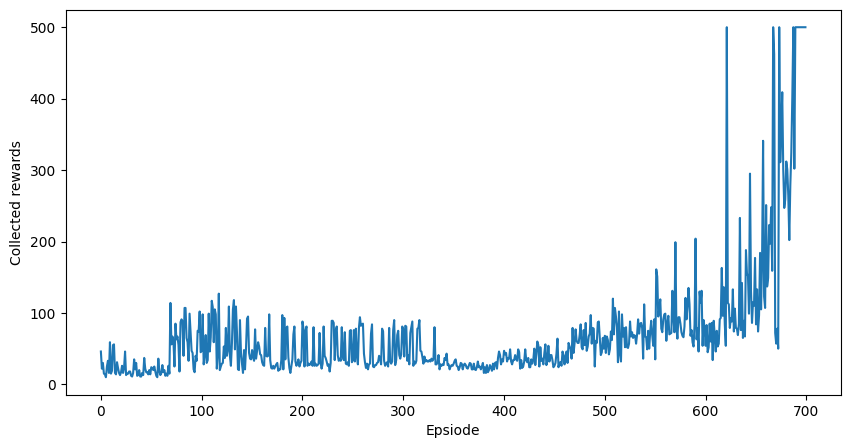

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(episode_reward_history)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()

Similarly to the plot above, you should see that after ~1000 episodes, the performance of the agent gets close to optimal, i.e., 500 rewards per episode. Learning takes longer for Q-learning agents since the Q-function is a "richer" function to be learned than the policy.

## 4. Exercise

Now that you have trained two different types of models, try experimenting with different environments (and different numbers of qubits and layers). You could also try combining the PQC models of the last two sections into an [actor-critic agent](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#actor-critic).